In [ ]:
!pip install shap

In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import xgboost
import lightgbm
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
import shap
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# generator_set = ["samcheonpo","yeongheung","yeongdong","gumi","gwangyanghang","dusan","gyeongsangUni","yecheon","goheungman"]
# algorithm_set = ["XG Boost", "Light GBM", "Cat Boost", "Random Forest"]



*   **Modeling**

In [ ]:
# select generator
generator = "dusan"
algorithm = "Random Forest"

# load dataset
path = '/content/drive/MyDrive/하늘/data files/feature_added/'+generator+'.csv'

df = pd.read_csv(path)
df = df.drop('Unnamed: 0', axis=1)
del_cols = ['date','year','month','day','hour','DoM','power_plant']
df = df.drop(columns = del_cols)

y_col = df['total_weighted_average_power']
df = df.drop(columns = ['total_weighted_average_power'])
df['total_weighted_average_power'] = y_col

# set variable X, target y
X=df.iloc[:,:-1]
y=df['total_weighted_average_power']

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# scaling
scaler = MinMaxScaler()
scaler.fit(X_train)
scaler.transform(X_train)
scaler.transform(X_test)

# select model, train
if(algorithm == "Random Forest"):
  model = RandomForestRegressor(n_estimators=100,
                                random_state=42).fit(X_train,y_train)
elif(algorithm == "XG Boost"):
  model = xgboost.XGBRegressor(colsample_bytree=0.055,
                             gamma=1.5,
                             learning_rate=0.02,
                             max_depth=12,
                             n_estimators=1000,
                             subsample=0.7,
                             booster='gbtree',
                             reg_alpha=0.0,
                             eval_metric = 'rmse',
                             random_state =7).fit(X_train,y_train)
elif(algorithm == "Light GBM"):
  model = lightgbm.LGBMRegressor(objective='regression',
                              num_leaves=144,
                              learning_rate=0.005,
                              n_estimators=1000,
                              max_depth=12,
                              metric='rmse',
                              is_training_metric=True,
                              max_bin = 55,
                              bagging_fraction = 0.8,
                              verbose=-1,
                              bagging_freq = 5,
                              feature_fraction = 0.9).fit(X_train,y_train)
elif(algorithm == "Cat Boost"):
  model = CatBoostRegressor(iterations=1000,
                              learning_rate=0.05,
                              depth=10,
                              eval_metric='RMSE',
                              random_seed=42,
                              logging_level='Silent').fit(X_train,y_train)

# evaluate the trained model

print(model)

pred = model.predict(X_test)
score = r2_score(y_test, pred)
print(score)

RandomForestRegressor(random_state=42)
0.4992129147494103




*   **Plotting**



Over 1504 , the average gap between the predicted y and the true y 9.0 MWh


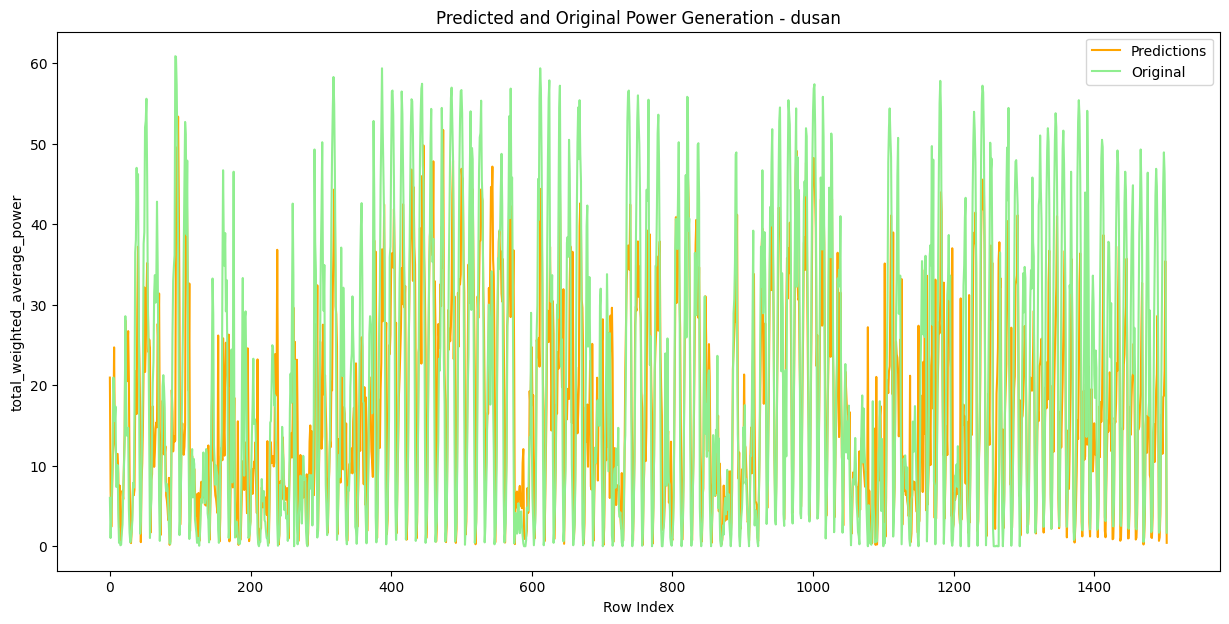

In [ ]:
# calculate the average gap between the predicted y and the true y

indexes_power_predicted = X_test.index
pred = np.array(pred)
original = np.array(df.loc[indexes_power_predicted, 'total_weighted_average_power'])

def average_gap(l1, l2):
    resu = 0
    for i in range(len(l1)):
        resu += np.abs(l1[i] - l2[i])
    resu = resu / len(l1)
    return resu

print("Over", len(pred), ", the average gap between the predicted y and the true y", round(average_gap(pred, original), 0), "MWh")

# plot y_hat and the true y

plt.figure(figsize=(15, 7))
plt.plot(range(len(pred)), pred, color="orange", label="Predictions")
plt.plot(range(len(original)), original, color="lightgreen", label="Original")
plt.title(f"Predicted and Original Power Generation - {generator}")
plt.xlabel("Row Index")
plt.ylabel("total_weighted_average_power")
plt.legend()
plt.show()



*  **SHAP Analysis**



In [ ]:
# calculate shap values for each feature

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

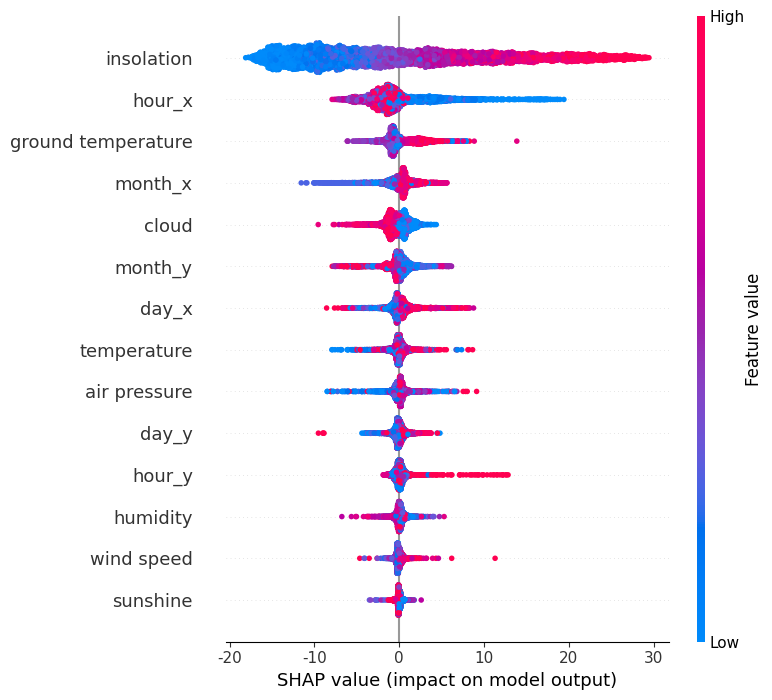

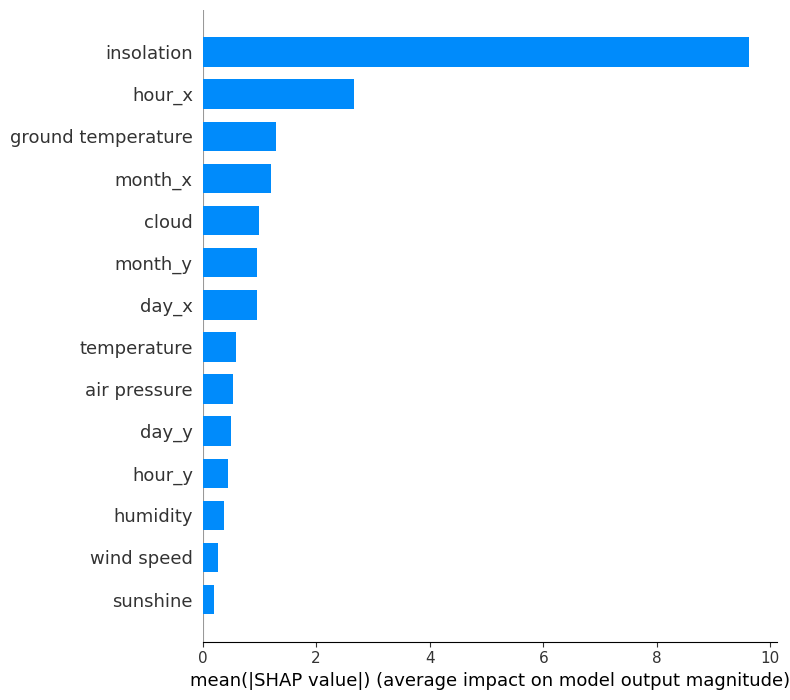

In [ ]:
# plot the influence of each
shap.summary_plot(shap_values, X_train, show=False)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/하늘/results/shap analysis/'+ generator + '/' + generator + '_impact.png')
plt.show()

shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/하늘/results/shap analysis/' + generator + '/' + generator + '_magnitude.png')
plt.show()

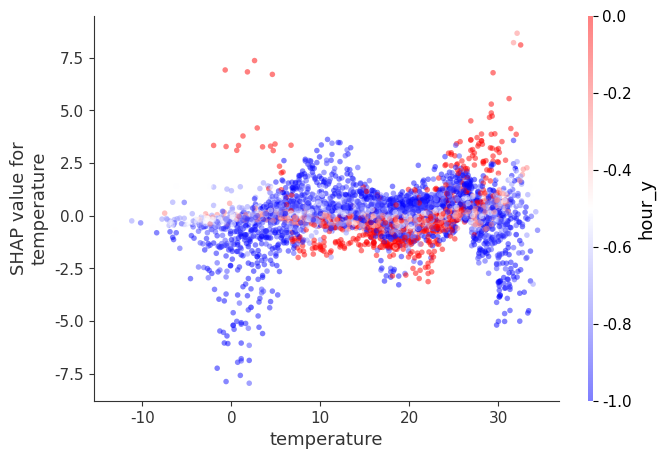

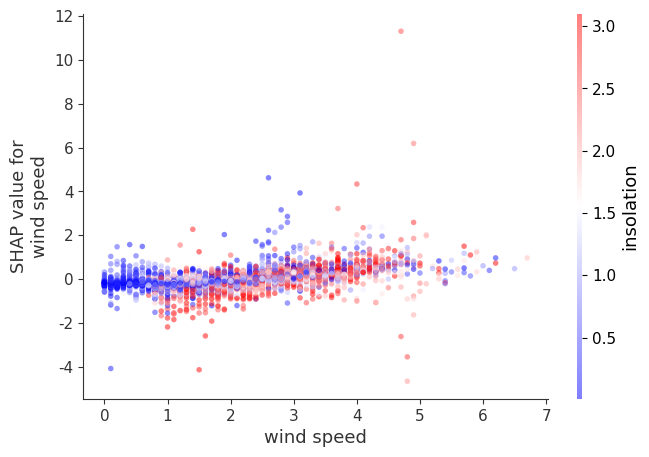

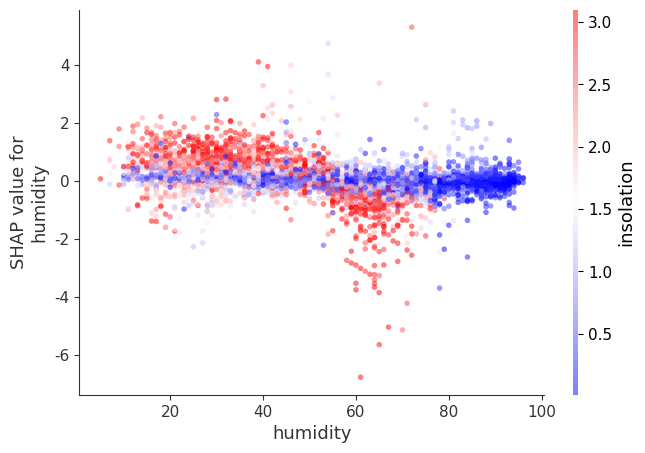

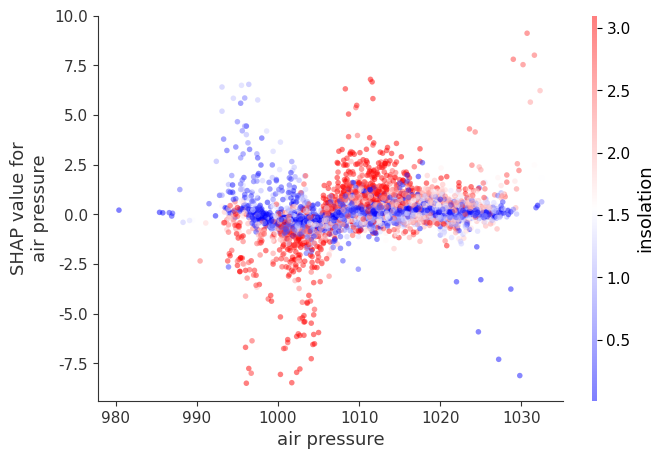

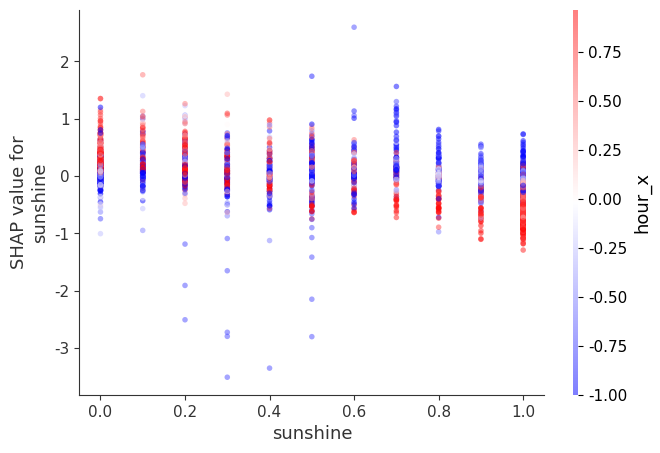

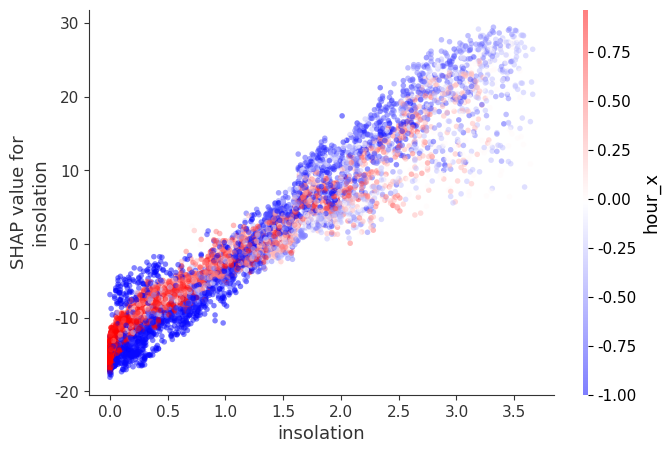

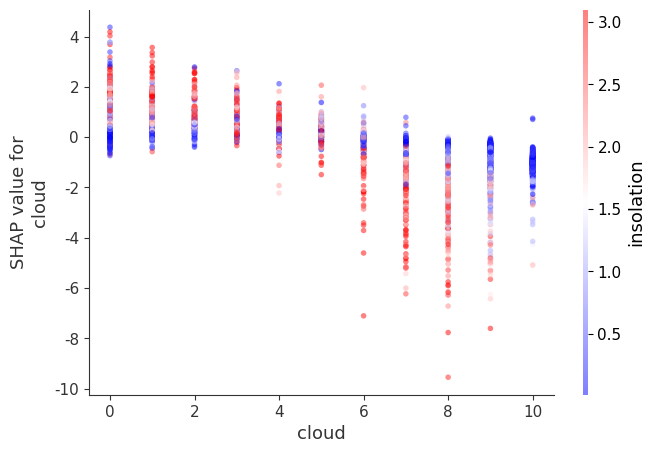

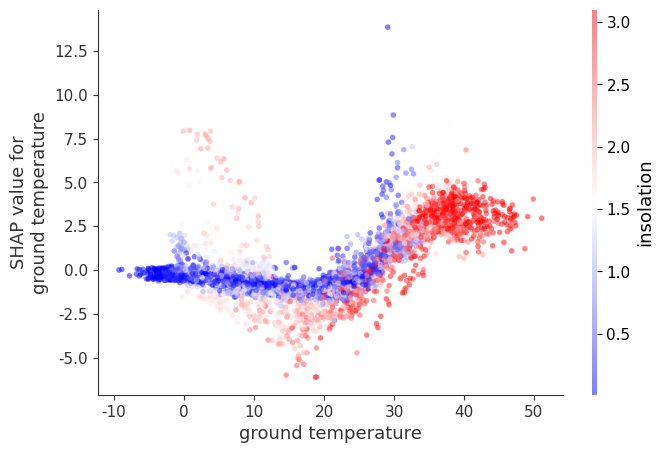

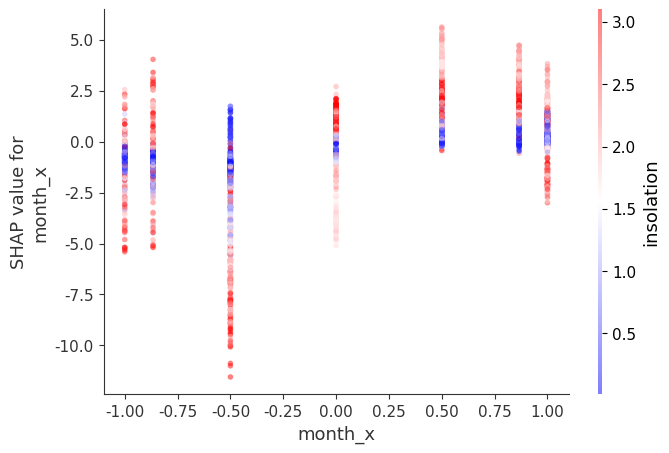

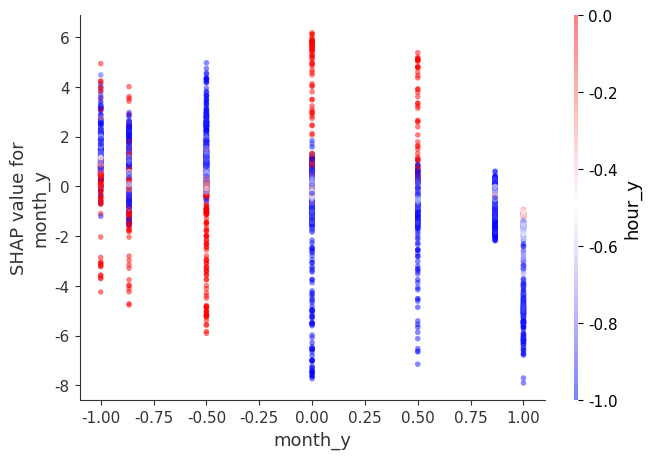

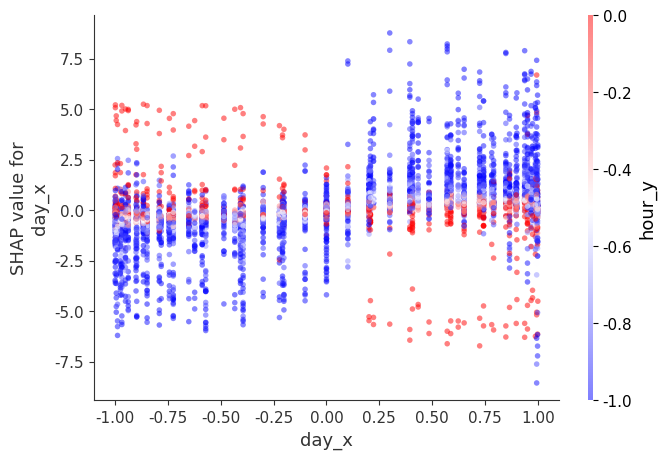

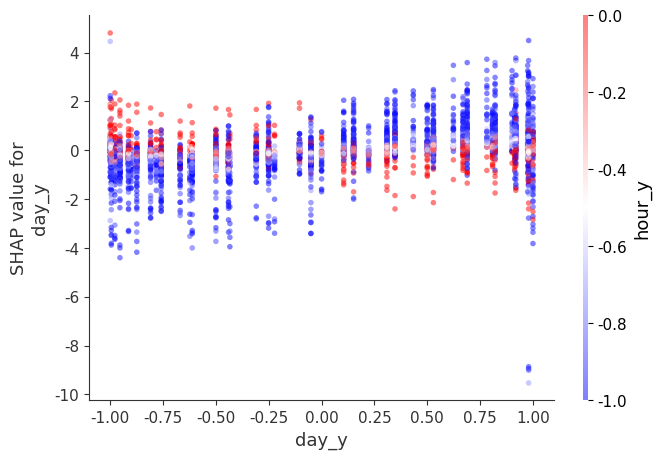

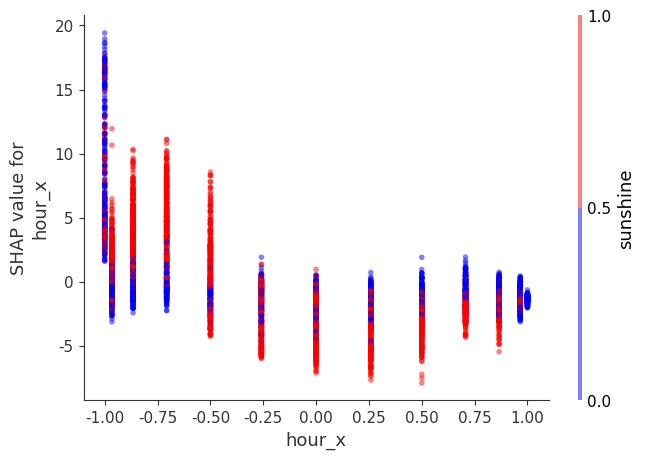

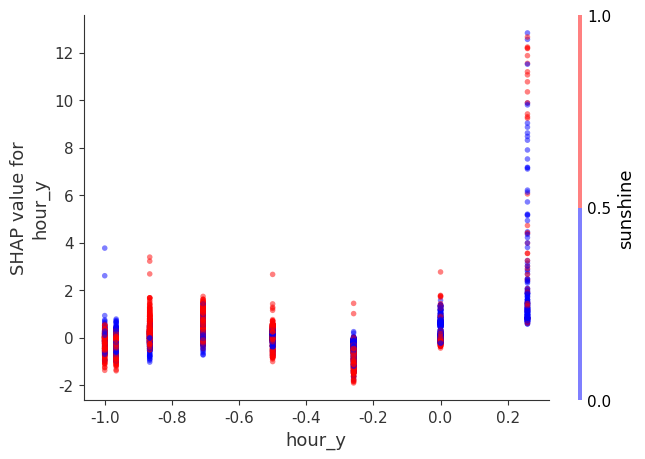

In [ ]:
# plot the dependency of two different features

for i in range(14):

  plt.rcParams['axes.unicode_minus'] = False
  shap.dependence_plot(i, shap_values, X_train,
                     feature_names=X.columns,
                     cmap=plt.cm.bwr,
                     alpha=0.5,
                     show=False
                     )
  # plt.title(f"Dependence Plot - {generator}", fontsize=14, loc='center')
  plt.savefig('/content/drive/MyDrive/하늘/results/shap analysis/' + generator + '/' + generator + '_' + X.columns[i] + '.jpg')
  plt.show()